In [1]:
import sys
import os
import pandas as pd
from pathlib import Path
import numpy as np
sys.path.insert(0, str(Path.cwd().parent))
from utils.utils import save_experiment, train_and_evaluate_linear_svm, grid_search_joblib, evaluate_model_on_parquet
from configs.config_local import FEATURES_DIR, ITW_DATASET_PATH, MODELS_PATH

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
import os

train_data_path = os.path.join(FEATURES_DIR, "training_features_mean_20_128_256_128.parquet")
val_data_path = os.path.join(FEATURES_DIR, "testing_features_mean_20_128_256_128.parquet")
test_data_path = os.path.join(ITW_DATASET_PATH, 'normalized_features', "itw_features_mean_20_128_256_128_trimmed_loudness_normalized.parquet")

model = Pipeline([
    ("scaler", StandardScaler()),
    ("svm",  LinearSVC(max_iter=20000, class_weight={0:1, 1:5}, random_state=42)),
])

param_grid = {
    "svm__C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
}



final_model, test_metrics, val_metrics, best_params, val_results, metadata, feature_names = grid_search_joblib(
                                                                                                                                model,
                                                                                                                                param_grid,
                                                                                                                                train_data_path,
                                                                                                                                val_data_path,
                                                                                                                                test_data_path,
                                                                                                                                n_jobs=5
                                                                                                                            )
print(f'Best parameters:{best_params}')
print(f'Resluts on validation data:{val_metrics}')
print(f'Resluts on test data:{test_metrics}')

save_experiment(
    model=final_model,
    metrics=test_metrics,
    experiment_dir=os.path.join(sys.path[0], "notebooks", "experiments", "linear_svm"),
    model_params=best_params,
    feature_names=feature_names,
    metadata_extra=metadata,
)

Number of fits: 7 with n_jobs=5 parallel jobs


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    8.5s
[Parallel(n_jobs=5)]: Done   2 out of   7 | elapsed:    9.7s remaining:   24.5s
[Parallel(n_jobs=5)]: Done   3 out of   7 | elapsed:   11.7s remaining:   15.6s
[Parallel(n_jobs=5)]: Done   4 out of   7 | elapsed:   14.3s remaining:   10.7s
[Parallel(n_jobs=5)]: Done   5 out of   7 | elapsed:   14.7s remaining:    5.8s
[Parallel(n_jobs=5)]: Done   7 out of   7 | elapsed:   17.9s finished


[1] {'svm__C': 0.001} | val_acc=0.7013 | val_f1=0.6730
[2] {'svm__C': 0.01} | val_acc=0.7052 | val_f1=0.6815
[3] {'svm__C': 0.1} | val_acc=0.7044 | val_f1=0.6810
[4] {'svm__C': 1} | val_acc=0.7037 | val_f1=0.6803
[5] {'svm__C': 10} | val_acc=0.7041 | val_f1=0.6809
[6] {'svm__C': 100} | val_acc=0.7041 | val_f1=0.6809
[7] {'svm__C': 1000} | val_acc=0.7041 | val_f1=0.6809

Best validation result:
  params: {'svm__C': 0.01}
  f1_macro: 0.6815
Best parameters:{'svm__C': 0.01}
Resluts on validation data:{'accuracy': 0.7052222701769529, 'precision': 0.7741288498521771, 'recall': 0.6993488243801345, 'f1': 0.6815274100862034, 'roc_auc': 0.8903954391614856}
Resluts on test data:{'accuracy': 0.7200406014083613, 'precision': 0.7074885236262592, 'recall': 0.718060558012356, 'f1': 0.70969285375347, 'roc_auc': 0.7811054568185785}
Experiment saved to: c:\Users\Konstantinos\Documents\GitHub\audio-deepfake-detection\notebooks\experiments\linear_svm\exp_20260131_215211


'c:\\Users\\Konstantinos\\Documents\\GitHub\\audio-deepfake-detection\\notebooks\\experiments\\linear_svm\\exp_20260131_215211'

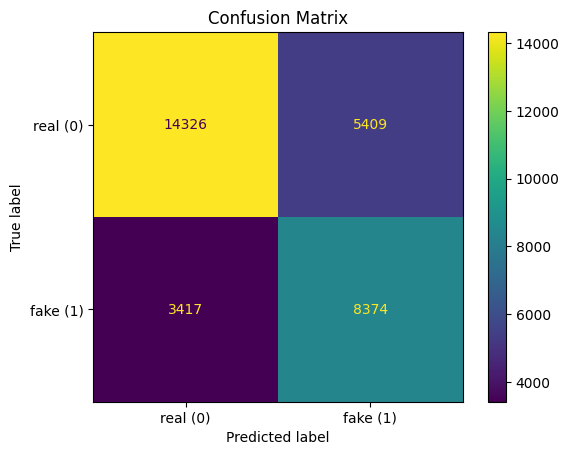

{'accuracy': 0.7200406014083613, 'precision': 0.6075600377276354, 'recall': 0.710202696972267, 'f1_macro': 0.70969285375347, 'roc_auc': 0.7811054568185785}


In [5]:
itw_test_data_path = os.path.join(ITW_DATASET_PATH, 'normalized_features',"itw_features_mean_20_128_256_128_trimmed_loudness_normalized.parquet")
metrics, metadata_extra = evaluate_model_on_parquet(final_model, itw_test_data_path, plots=True)
print(metrics)


### Features Importance

In [11]:
best_model_path = os.path.join(MODELS_PATH, 'linear_svm','exp_20260131_215211', 'model.joblib')
import joblib

model = joblib.load(best_model_path)

svm = model.named_steps["svm"]

importance = np.abs(svm.coef_).ravel()

len(importance)

195

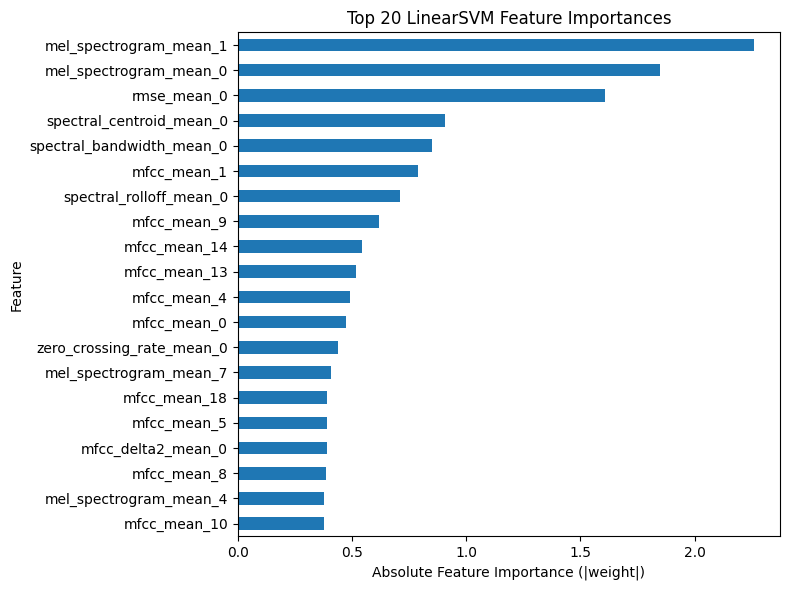

In [13]:
import pandas as pd
train_data_path = os.path.join(FEATURES_DIR, "training_features_mean_20_128_256_128.parquet")
train_data=pd.read_parquet(itw_test_data_path)

train_data.drop(columns=['label', 'filename'], inplace=True)
features_names= train_data.columns
feature_importance = pd.Series(
    importance,
    index=features_names
).sort_values(ascending=False)


import matplotlib.pyplot as plt

top20 = feature_importance.head(20)

plt.figure(figsize=(8, 6))
top20.sort_values().plot(kind="barh")
plt.xlabel("Absolute Feature Importance (|weight|)")
plt.ylabel("Feature")
plt.title("Top 20 LinearSVM Feature Importances")
plt.tight_layout()
plt.show()





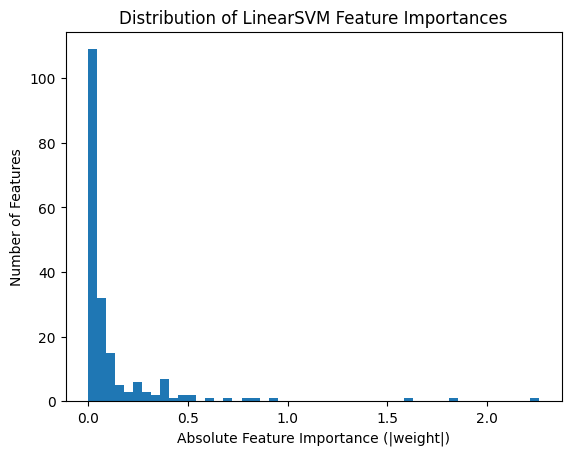

In [8]:
import matplotlib.pyplot as plt
import numpy as np

importance = np.abs(model.named_steps["svm"].coef_).ravel()

plt.figure()
plt.hist(importance, bins=50)
plt.xlabel("Absolute Feature Importance (|weight|)")
plt.ylabel("Number of Features")
plt.title("Distribution of LinearSVM Feature Importances")
plt.show()
